# Exploration
- find rails and pockets
- store constants

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json

constants = {}

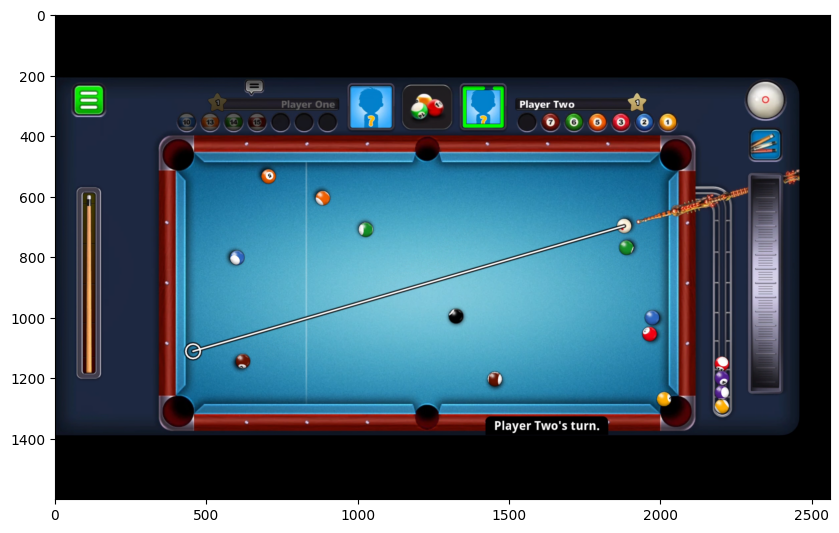

In [ ]:
# load and show image
img = cv2.imread('screenshots/screenshot_3.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(img)

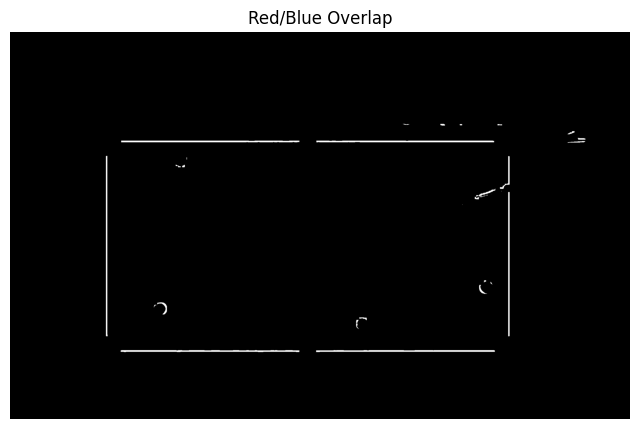

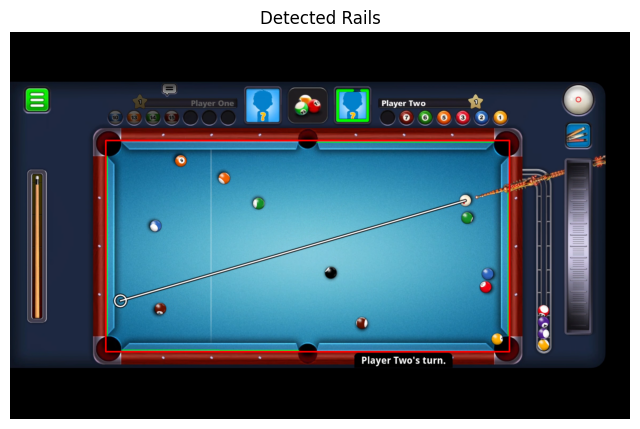

In [90]:
# detect rails to get rectangular playable area

# IDEA: find border of reddish brown and blue areas (gets the rails)

# hsv for better color detection
hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

# hsv color ranges for red (170-180 and 0-10) and blue (90-130)
lower_red1 = np.array([0, 100, 50])
upper_red1 = np.array([10, 255, 255])
lower_red2 = np.array([170, 100, 50])
upper_red2 = np.array([180, 255, 255])
lower_blue = np.array([90, 50, 150])
upper_blue = np.array([130, 255, 255])

# red/blue masks
mask_red1 = cv2.inRange(hsv, lower_red1, upper_red1)
mask_red2 = cv2.inRange(hsv, lower_red2, upper_red2)
mask_red = cv2.bitwise_or(mask_red1, mask_red2)
mask_blue = cv2.inRange(hsv, lower_blue, upper_blue)

# dilate masks so they have overlap (so we can intersect)
kernel = np.ones((5, 5), np.uint8)
dilated_red = cv2.dilate(mask_red, kernel, iterations=2)
dilated_blue = cv2.dilate(mask_blue, kernel, iterations=2)

# intesrect the dilated masks to find adjacent areas
adjacent_mask = cv2.bitwise_and(dilated_red, dilated_blue)

# find rails
edges = cv2.Canny(adjacent_mask, 100, 150, apertureSize=3)
lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=50, minLineLength=200, maxLineGap=30)

img_with_rails = img.copy()
# get top left and bottom right corners of the playable area
tl_x, tl_y, br_x, br_y = float('inf'), float('inf'), float('-inf'), float('-inf')
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(img_with_rails, (x1, y1), (x2, y2), (0, 255, 0), 2)
    tl_x = min(tl_x, x1, x2)
    tl_y = min(tl_y, y1, y2)
    br_x = max(br_x, x1, x2)
    br_y = max(br_y, y1, y2)

# draw rectangle around playable area
cv2.rectangle(img_with_rails, (tl_x, tl_y), (br_x, br_y), (255, 0, 0), 5)

plt.figure(figsize=(8, 8))
# show red/blue overlap
plt.imshow(adjacent_mask, cmap='gray')
plt.axis('off')
plt.title('Red/Blue Overlap')
plt.show()

# show image with green lines for rails
plt.figure(figsize=(8, 8))
plt.imshow(img_with_rails)
plt.title('Detected Rails')
plt.axis('off')
plt.show()

# save coordinates of playable area
constants['playable_area'] = {
    'top_left': (int(tl_x), int(tl_y)),
    'bottom_right': (int(br_x), int(br_y))
}



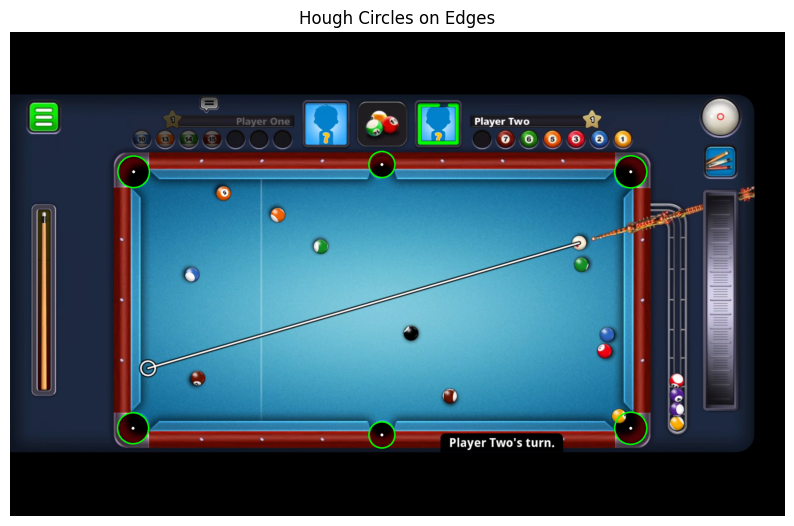

[(406, 1310), (2050, 464), (408, 464), (2050, 1310), (1228, 1332), (1228, 440)]


In [ ]:
# detect pockets
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
high_contrast = cv2.convertScaleAbs(gray, alpha=1.5, beta=0)
blurred = cv2.GaussianBlur(high_contrast, (7, 7), 0)

# hough circles
circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=1, minDist=50,
                          param1=70, param2=35, minRadius=30, maxRadius=60)

result = img.copy()
if circles is not None:
    circles = np.uint16(np.around(circles))
    playable_tl = constants['playable_area']['top_left']
    playable_br = constants['playable_area']['bottom_right']
    filtered_circles = []
    for i in circles[0, :]:
        # check if circle's center is within playable area (some buffer)
        if (playable_tl[0] - 25 <= i[0] <= playable_br[0] + 25 and
                playable_tl[1] - 25 <= i[1] <= playable_br[1] + 25):
            filtered_circles.append(i)
            # draw circle and white center point
            cv2.circle(result, (i[0], i[1]), i[2], (0, 255, 0), 3)
            cv2.circle(result, (i[0], i[1]), 2, (255, 255, 255), 5)
    circles = np.array(filtered_circles)

plt.figure(figsize=(10, 10))
plt.imshow(result)
plt.title('Hough Circles on Edges')
plt.axis('off')
plt.show()

# save pocket coordinates
if circles is not None:
    pocket_coords = []
    for i in circles:
        pocket_coords.append((int(i[0]), int(i[1])))
    constants['pockets'] = pocket_coords
print(constants['pockets'])

In [101]:
# save constants to json file
with open('constants.json', 'w') as f:
    json.dump(constants, f, indent=4)